In [12]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [13]:
import pandas as pd
import numpy as np
import math

import torch
import torch.nn as nn
import torch.optim as optim
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [14]:
# def read_excel()
xl = pd.ExcelFile('.Data/GoldData.xlsx')
data = {}
for f in (xl.sheet_names):
    data[f] = pd.read_excel('.Data/GoldData.xlsx',sheet_name = f).set_index('Date')
orig_cols = [*data]

In [15]:
data['USInf_1M_Chg'] = data['USInf'].sort_values('Date').pct_change(1)
data['USInf_12M_Chg'] = data['USInf'].sort_values('Date').pct_change(12)
data['USInf_12M_Chg_3M_Chg'] = (data['USInf_12M_Chg'] - data['USInf_12M_Chg'].shift(4))
data['Unemployment_norm'] = (data['Unemployment'].sort_values('Date')-data['Unemployment'].mean())/(data['Unemployment'].std())
data['Unemployment_norm_1Prd_Chg'] = (data['Unemployment_norm'] - data['Unemployment_norm'].shift(1))



In [23]:
df = data['Gold']
df.columns = ['Gold']
for c in [*data][1:]:
    dat=data[c]
    dat.columns = [c]
    df = df.merge(dat,left_index=True, right_index=True, how='left')
    
df = df.sort_values('Date').fillna(method = 'ffill')
df['Gold_Ret_1d']=df['Gold'].pct_change(1)
df['Gold_Ret_5d']=df['Gold'].pct_change(5)
df['Gold_Ret_20d']=df['Gold'].pct_change(20)
df['Gold_Ret_180d']=df['Gold'].pct_change(180)
df['Gold_Std_5d']=df['Gold_Ret_1d'].rolling(5).std()
df['Gold_Std_20d']=df['Gold_Ret_1d'].rolling(20).std()
df['Gold_Std_180d']=df['Gold_Ret_1d'].rolling(180).std()
df['DollarIndex_Ret_1d']=df['DollarIndex'].pct_change(1)
df['DollarIndex_Ret_5d']=df['DollarIndex'].pct_change(5)
df['DollarIndex_Ret_20d']=df['DollarIndex'].pct_change(20)
df['DollarIndex_Ret_180d']=df['DollarIndex'].pct_change(180)
df['SPX_Ret_1d']=df['SPX'].pct_change(1)
df['SPX_Ret_5d']=df['SPX'].pct_change(5)
df['SPX_Ret_20d']=df['SPX'].pct_change(20)
df['SPX_Ret_180d']=df['SPX'].pct_change(180)
df['VIX_Normalized'] = ((df['Vix']-df['Vix'].min())/(df['Vix'].max()-df['Vix'].min()))
df['VIX_Normalized_Chg_5d']=df['VIX_Normalized']-df['VIX_Normalized'].shift(5)
df['FedFundRate_Norm'] = ((df['FedFundRate']-df['FedFundRate'].min())/(df['FedFundRate'].max()-df['FedFundRate'].min()))
df['FedFundRate_Norm_Chg_60d']=df['FedFundRate_Norm']-df['FedFundRate_Norm'].shift(61)
df['Spread10Y-2Y'] = df['Govt10']-df['Govt2']


df['Gold_Ret_Fut_1d'] =  [0 if a<0 else 1 for a in df['Gold'].pct_change(1).shift(-1) ]
df['Gold_Ret_Fut_5d'] = [0 if a<0 else 1 for a in df['Gold'].pct_change(5).shift(-5) ]
df['Gold_Ret_Fut_20d'] = [0 if a<0 else 1 for a in df['Gold'].pct_change(20).shift(-20) ]
# df['Gold_Ret_Fut_180d'] = df['Gold'].pct_change(-180)
# df['Gold_Std_Fut_5d'] = df['Gold_Ret_1d'].rolling(5).std().shift(-5)
# df['Gold_Std_Fut_20d'] = df['Gold_Ret_1d'].rolling(20).std().shift(-20)
# df['Gold_Std_Fut_180d'] = df['Gold_Ret_1d'].rolling(180).std().shift(-180)
df

,Gold,USInf,DollarIndex,FedFundRate,SPX,Vix,Govt10,Govt2,Unemployment,USInf_1M_Chg,...,SPX_Ret_20d,SPX_Ret_180d,VIX_Normalized,VIX_Normalized_Chg_5d,FedFundRate_Norm,FedFundRate_Norm_Chg_60d,Spread10Y-2Y,Gold_Ret_Fut_1d,Gold_Ret_Fut_5d,Gold_Ret_Fut_20d
Date,,,,,,,,,,,,,,,,,,,,,
1995-01-02,383.00,NaN,NaN,4.94,NaN,NaN,7.831,7.699,NaN,NaN,...,NaN,NaN,NaN,NaN,0.631443,NaN,0.132,0,0,0
1995-01-03,379.85,NaN,89.110,5.98,459.11,14.25,7.875,7.725,NaN,NaN,...,NaN,NaN,0.069477,NaN,0.765464,NaN,0.150,0,0,0
1995-01-04,374.30,NaN,89.310,6.59,460.71,13.53,7.815,7.621,NaN,NaN,...,NaN,NaN,0.059687,NaN,0.844072,NaN,0.194,1,1,1
1995-01-05,374.75,NaN,88.980,5.72,460.34,13.50,7.854,7.647,NaN,NaN,...,NaN,NaN,0.059279,NaN,0.731959,NaN,0.207,0,1,1
1995-01-06,371.50,NaN,89.610,5.52,460.68,13.13,7.858,7.621,NaN,NaN,...,NaN,NaN,0.054249,NaN,0.706186,NaN,0.237,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-17,1955.04,305.11,99.842,5.08,4522.79,13.48,3.810,4.745,3.57,0.003232,...,0.025671,0.202969,0.059007,-0.021618,0.649485,0.032216,-0.935,1,1,1
2023-07-18,1978.72,305.11,99.941,5.08,4554.98,13.30,3.788,4.769,3.57,0.003232,...,0.037886,0.224493,0.056560,-0.020938,0.649485,0.032216,-0.981,0,1,1
2023-07-19,1976.64,305.11,100.281,5.08,4565.72,13.76,3.750,4.767,3.57,0.003232,...,0.045819,0.210890,0.062814,0.002991,0.649485,0.032216,-1.017,0,1,1


In [24]:
df_orig = df.copy()

df = df[df.index>='1996-01-01']
# df.to_excel('/Users/varunbatra/Desktop/data_final.xls')
df = df.drop(orig_cols, axis=1).dropna(axis=0)

In [25]:
# output_cols = ['Gold_Ret_Fut_1d','Gold_Ret_Fut_5d','Gold_Ret_Fut_20d','Gold_Ret_Fut_180d','Gold_Std_Fut_5d','Gold_Std_Fut_20d','Gold_Std_Fut_180d']
output_cols=['Gold_Ret_Fut_1d','Gold_Ret_Fut_5d', 'Gold_Ret_Fut_20d']
df_input = df.drop(output_cols, axis=1)
df_output = df[output_cols]

In [96]:
train_upto = '2017-12-31'
X_train = df_input[df_input.index<=train_upto]
X_val = df_input[df_input.index>train_upto]
y_train = df_output[df_output.index<=train_upto]
y_val = df_output[df_output.index>train_upto]

# X_train, X_val, y_train, y_val = train_test_split(df_input, df_output, test_size=0.666, stratify=df_output, random_state=0)


train_data = torch.tensor(X_train.values.astype(np.float32))
train_targets = torch.tensor(y_train.values.astype(np.float32))
val_data = torch.tensor(X_val.values.astype(np.float32))
val_targets = torch.tensor(y_val.values.astype(np.float32))




In [97]:

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layer1 = nn.Linear(hidden_size, hidden_size)
        self.hidden_layer2 = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.input_layer(x))
        x = self.relu(self.hidden_layer1(x))
        x = self.relu(self.hidden_layer2(x))
        x = self.sigmoid(self.output_layer(x))
        return x

In [98]:
# Define the hyperparameter search space
dimensions = [
    Integer(low=25, high=300, name='hidden_size'),
    Real(low=1e-4, high=0.1, prior='log-uniform', name='learning_rate'),
    Integer(low=50, high=400, name='epochs'),
]
dimensions

[Integer(low=25, high=300, prior='uniform', transform='identity'),
 Real(low=0.0001, high=0.1, prior='log-uniform', transform='identity'),
 Integer(low=50, high=400, prior='uniform', transform='identity')]

In [99]:
# Generate some sample input data, targets, and validation data
input_size = len(df_input.columns)
output_size = len(df_output.columns)
print(input_size,output_size)

25 3


In [100]:
def train_neural_network(hidden_size, learning_rate, epochs, input_size, output_size, train_data, train_targets, val_data, val_targets):
    model = NeuralNetwork(input_size, hidden_size, output_size)    
    criterion = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(train_data)
        loss = criterion(outputs, train_targets)
        loss.backward()
        optimizer.step()

        val_outputs = model(val_data)
        val_loss = criterion(val_outputs, val_targets)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

    return train_losses, val_losses

# Perform Bayesian optimization to optimize hyperparameters
@use_named_args(dimensions=dimensions)
def fitness(hidden_size, learning_rate, epochs):
    print(hidden_size, learning_rate, epochs)
    train_losses, val_losses = train_neural_network(hidden_size=hidden_size, learning_rate=learning_rate,
                                epochs=epochs, input_size=input_size, output_size=output_size,
                                train_data=train_data, train_targets=train_targets,
                                val_data=val_data, val_targets=val_targets)
    
    return min(val_losses)

result = gp_minimize(func=fitness, dimensions=dimensions, n_calls=10, random_state=42)

244 0.000355062142707077 323
189 0.002175195311877766 85
151 0.0010025956902289567 100
204 0.00014765043713594345 303
283 0.00010053940194693022 397
195 0.0068384784309640494 52
31 0.0037525283395739802 190
38 0.08341930294140788 131
50 0.007164040428191017 184
295 0.0025135566617708297 351


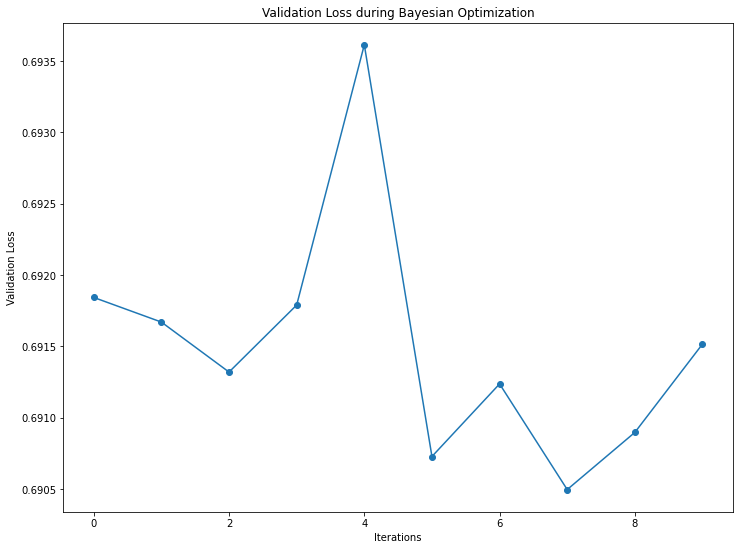

Best Hyperparameters:
Hidden Size: 38
Learning Rate: 0.08341930294140788
Epochs: 131


In [101]:
# Plot the scores during optimization
scores = result.func_vals
plt.figure(figsize=(12, 9))
plt.plot(scores[:16], marker='o')
plt.xlabel('Iterations')
plt.ylabel('Validation Loss')
plt.title('Validation Loss during Bayesian Optimization')
plt.show()

# Get the best hyperparameters
best_hidden_size = result.x[0]
best_learning_rate = result.x[1]
best_epochs = result.x[2]

print("Best Hyperparameters:")
print("Hidden Size:", best_hidden_size)
print("Learning Rate:", best_learning_rate)
print("Epochs:", best_epochs)

In [102]:
model = NeuralNetwork(25, best_hidden_size, 3)
criterion = criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=best_learning_rate)

train_losses = []
val_losses = []
for epoch in range(best_epochs):
    optimizer.zero_grad()
    outputs = model(train_data)
    loss = criterion(outputs, train_targets)
    loss.backward()
    optimizer.step()

    val_outputs = model(val_data)
    val_loss = criterion(val_outputs, val_targets)
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

val_outputs = model(val_data)
val_loss = criterion(val_outputs, val_targets)


# train_losses.append(loss.item())
# val_losses.append(val_loss.item())


In [103]:
out = y_val.merge(pd.DataFrame(val_outputs.detach().numpy(),columns =[a+'_pred' for a in output_cols], index = y_val.index ),left_index=True, right_index=True, how='left')
out = out.merge(data['Gold'],left_index=True, right_index=True, how='left')
out['Fwd_1d_Ret']=out['Gold'].pct_change(1).shift(-1)
out.head()

,Gold_Ret_Fut_1d,Gold_Ret_Fut_5d,Gold_Ret_Fut_20d,Gold_Ret_Fut_1d_pred,Gold_Ret_Fut_5d_pred,Gold_Ret_Fut_20d_pred,Gold,Fwd_1d_Ret
Date,,,,,,,,
2018-01-02,0,0,1,0.556474,0.634699,0.783353,1317.56,-0.003302
2018-01-03,1,1,1,0.548194,0.595575,0.692782,1313.21,0.007463
2018-01-04,0,0,1,0.537013,0.534086,0.522944,1323.01,-0.002585
2018-01-05,1,1,1,0.545279,0.551033,0.564639,1319.59,0.000614
2018-01-08,0,1,1,0.540650,0.536674,0.520461,1320.40,-0.005718


<AxesSubplot:xlabel='Date'>

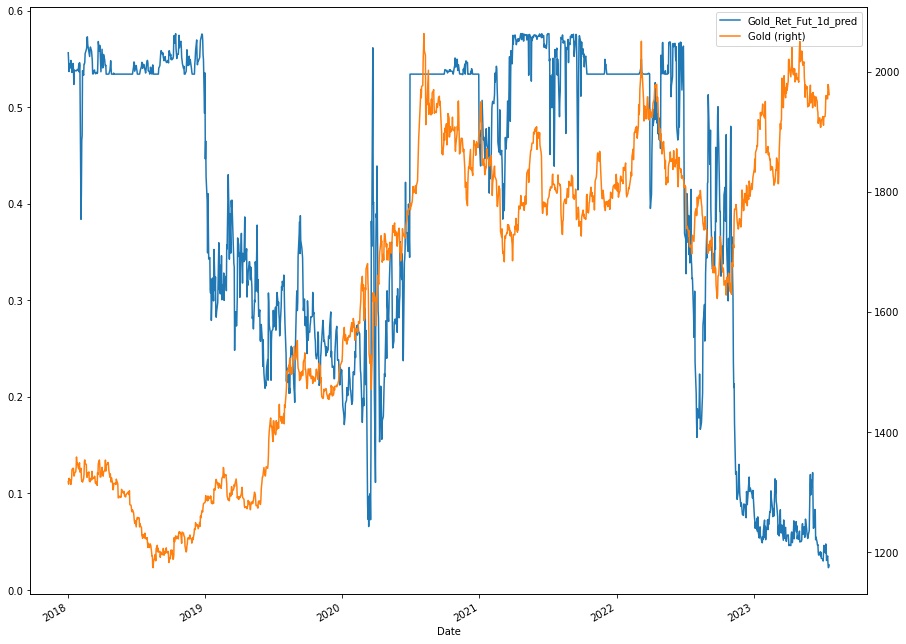

In [104]:

out[['Gold_Ret_Fut_1d_pred','Gold']].plot(secondary_y=["Gold"],figsize=(15, 12))

<AxesSubplot:xlabel='Date'>

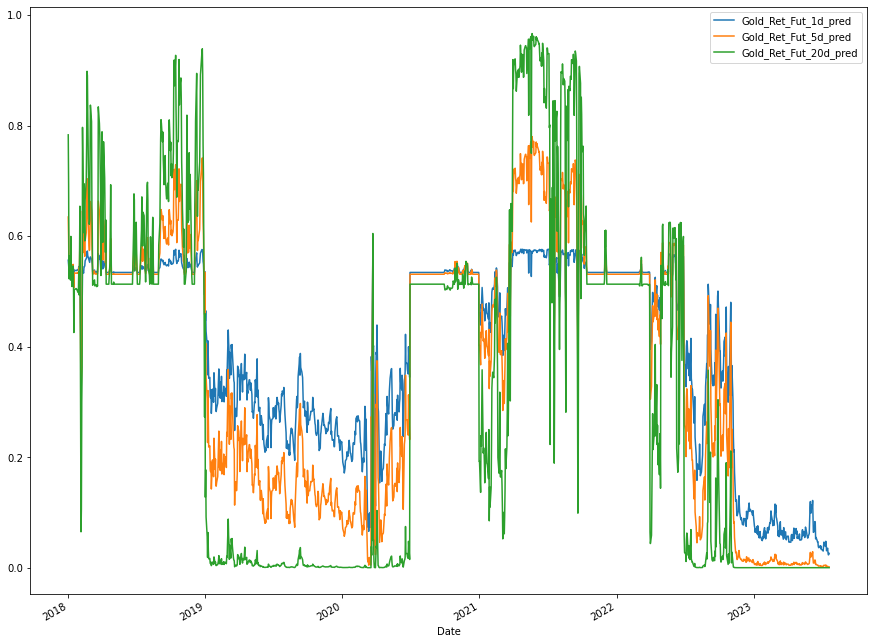

In [105]:
out[['Gold_Ret_Fut_1d_pred','Gold_Ret_Fut_5d_pred','Gold_Ret_Fut_20d_pred']].plot(figsize=(15, 12))

<AxesSubplot:xlabel='Date'>

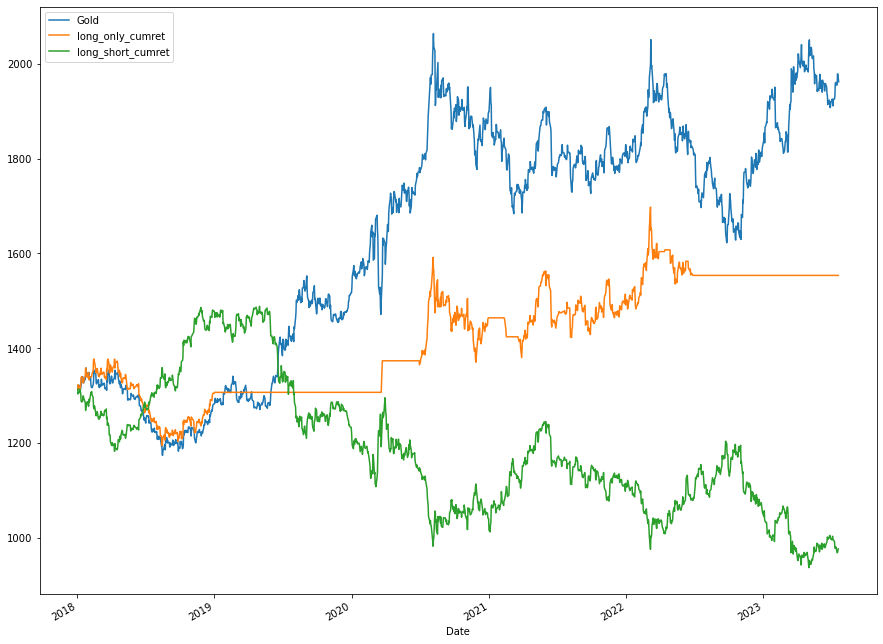

In [109]:
out['long_only'] = [1 if a>=.52 else 0 for a in out['Gold_Ret_Fut_1d_pred']]

out['long_short'] = [1 if a>=.55 else -1 for a in out['Gold_Ret_Fut_1d_pred']]

out['long_only_ret'] = out['long_only']*out['Fwd_1d_Ret']+1

out['long_short_ret'] = out['long_short']*out['Fwd_1d_Ret']+1

out['long_only_cumret'] = out['long_only_ret'].cumprod()*out['Gold'][0]

out['long_short_cumret'] = out['long_short_ret'].cumprod()*out['Gold'][0]

out[['Gold','long_only_cumret','long_short_cumret']].plot(figsize=(15, 12))

In [110]:
# Conclusion

'''
Gold forecast model gives better sharp ratio than just being long in Gold. However, more work is needed and various combination of input features nees to be tried.

I would also like to try less black box models like random forests and see if I can get similar/better results.

Hopefully, One day, I will find that holy grail of function and become rich and can retire, sigh...

One thing however is the function shows some jumps when a major event happens and does create short term trading opprtunities. 

The output level of sigmoid function gives conviction level and its interesting to see that when short term conviction jumps, price does follow, however more evidence is needed. Overall results are Ok but not mind blowing..
'''




'\nGold forecast model gives better sharp ratio than just being long in Gold. However, more work is needed and various combination of input features nees to be tried.\n\nI would also like to try less black box models like random forests and see if I can get similar/better results.\n\nHopefully, One day, I will find that holy grail of function and become rich and can retire, sigh...\n\nOne thing however is the function shows some jumps when a major event happens and does create short term trading opprtunities. \n\nThe output level of sigmoid function gives conviction level and its interesting to see that when short term conviction jumps, price does follow, however more evidence is needed. Overall results are Ok.\n'

In [123]:
from sklearn.metrics import confusion_matrix, accuracy_score
# cm = confusion_matrix(y_true, y_pred)
# acc = accuracy_score(y_true, y_pred)

array([0., 0., 0., ..., 1., 1., 1.], dtype=float32)

In [129]:
cm_train = confusion_matrix(train_targets.detach().numpy().round()[:,0], model(train_data).detach().numpy().round()[:,0])
acc_train = accuracy_score(model(train_data).detach().numpy().round()[:,0], train_targets.detach().numpy().round()[:,0])
print('Confusion Matrix Train:\n',cm_train)
print('Accuracy Train:\n',acc_train)


Confusion Matrix:
 [[ 776 1929]
 [ 650 2270]]
Accuracy:
 0.5415111111111112


In [130]:
cm_val = confusion_matrix(val_targets.detach().numpy().round()[:,0], model(val_data).detach().numpy().round()[:,0])
acc_val = accuracy_score(model(val_data).detach().numpy().round()[:,0], val_targets.detach().numpy().round()[:,0])
print('Confusion Matrix Val:\n',cm_val)
print('Accuracy Val:\n',acc_val)


Confusion Matrix Val:
 [[347 331]
 [396 371]]
Accuracy Val:
 0.49688581314878894
